# AI/ML Security Testing: Backdoor Attacks

### Introduction

This notebook provides a step-by-step demonstration of how to perform backdoor attacks against machine learning models based on the CyBOK Security and Privacy of AI Knowledge Guide. Backdoor attacks insert hidden functionality into a model during training, causing it to misclassify inputs containing a specific trigger pattern.

We'll use a simple MNIST digit classifier as our target and demonstrate:
1. Training a baseline model
2. Creating and implementing a backdoor attack
3. Testing the effectiveness of the backdoor
4. Implementing defensive measures

### Setup and Dependencies

 Let's start by importing the necessary libraries and setting up our environment:



In [2]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import os
import time

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Create directories for outputs
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)

print("Environment setup complete!")

2025-04-13 15:40:47.440224: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-13 15:40:48.189066: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744555248.452940   12196 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744555248.532250   12196 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744555249.128304   12196 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

Environment setup complete!




### 1. Loading and Preparing the MNIST Dataset

First, we'll load the MNIST dataset and preprocess it for training:


In [3]:

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Print dataset shapes
print(f"Training data shape: {x_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

# Normalize pixel values to be between 0 and 1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape to include channel dimension (MNIST is grayscale, so 1 channel)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Convert class vectors to binary class matrices (one-hot encoding)
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

print("Data preprocessing completed.")

Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)
Data preprocessing completed.




Let's visualize some examples from the dataset to understand what we're working with:


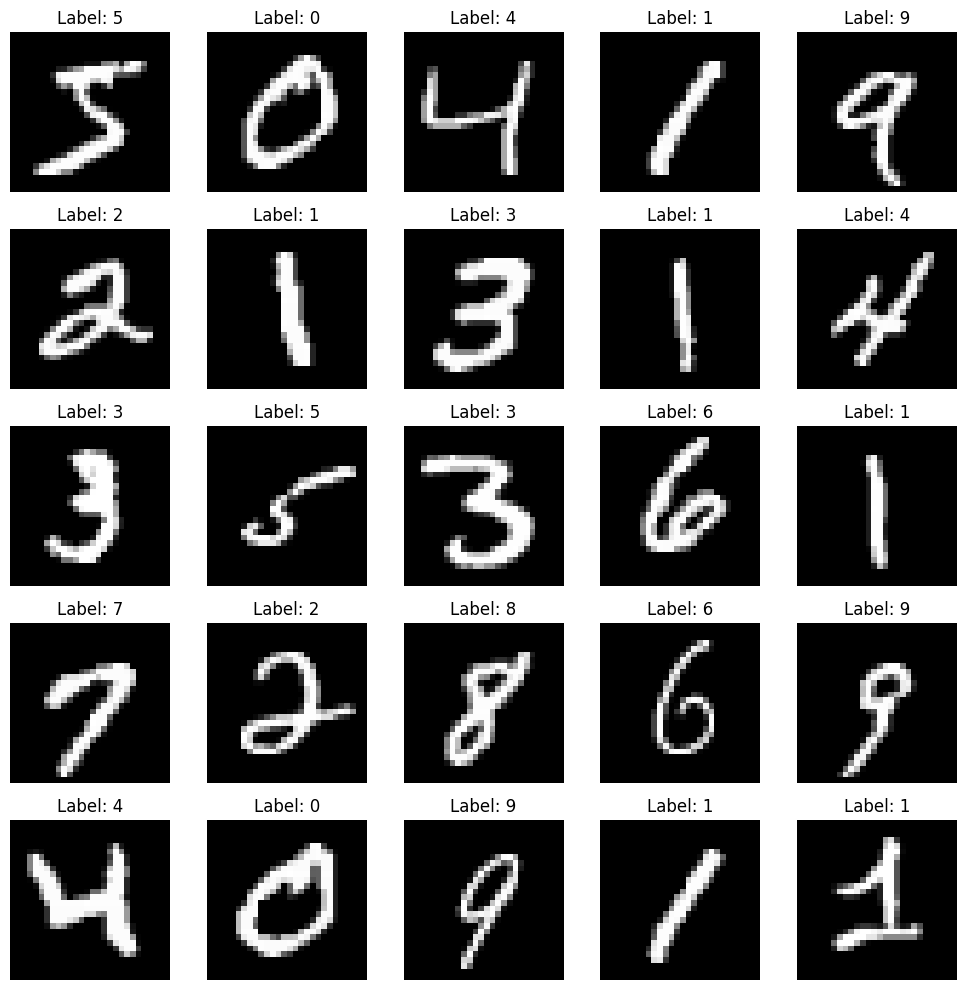

In [4]:

# Visualize some examples from the dataset
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()



## 2. Building and Training a Clean Model

Now we'll create a simple Convolutional Neural Network (CNN) for digit classification:



In [5]:

def build_model():
    model = Sequential([
        # First convolutional layer
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        
        # Second convolutional layer
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        
        # Flatten layer
        Flatten(),
        
        # Fully connected layers
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(10, activation='softmax')
    ])
    
    # Compile model
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create model
model = build_model()

# Display model summary
model.summary()

/home/cybok/Desktop/cybok/cybokenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-04-13 15:40:58.932178: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)




Now let's train the model on the clean MNIST data:



In [6]:

# Train the model
history = model.fit(
    x_train, y_train_cat,
    batch_size=128,
    epochs=10,
    validation_data=(x_test, y_test_cat),
    verbose=1
)

# Save the clean model
model.save('models/mnist_clean_model.h5')
print("Clean model saved as 'models/mnist_clean_model.h5'")

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 25s 51ms/step - accuracy: 0.8399 - loss: 0.5295 - val_accuracy: 0.9785 - val_loss: 0.0651
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - accuracy: 0.9787 - loss: 0.0725 - val_accuracy: 0.9833 - val_loss: 0.0496
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - accuracy: 0.9850 - loss: 0.0499 - val_accuracy: 0.9863 - val_loss: 0.0369
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9876 - loss: 0.0404 - val_accuracy: 0.9880 - val_loss: 0.0355
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9909 - loss: 0.0315 - val_accuracy: 0.9912 - val_loss: 0.0277
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - accuracy: 0.9925 - loss: 0.0252 - val_accuracy: 0.9891 - val_loss: 0.0364
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.9942 - loss: 0.0215 - val_accuracy: 0.9922 - val_loss: 0.0263
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.9946 - loss: 0.0175 - 

Clean model saved as 'models/mnist_clean_model.h5'




Let's evaluate the clean model's performance:


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9879 - loss: 0.0367
Test Loss: 0.0293
Test Accuracy: 0.9908
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


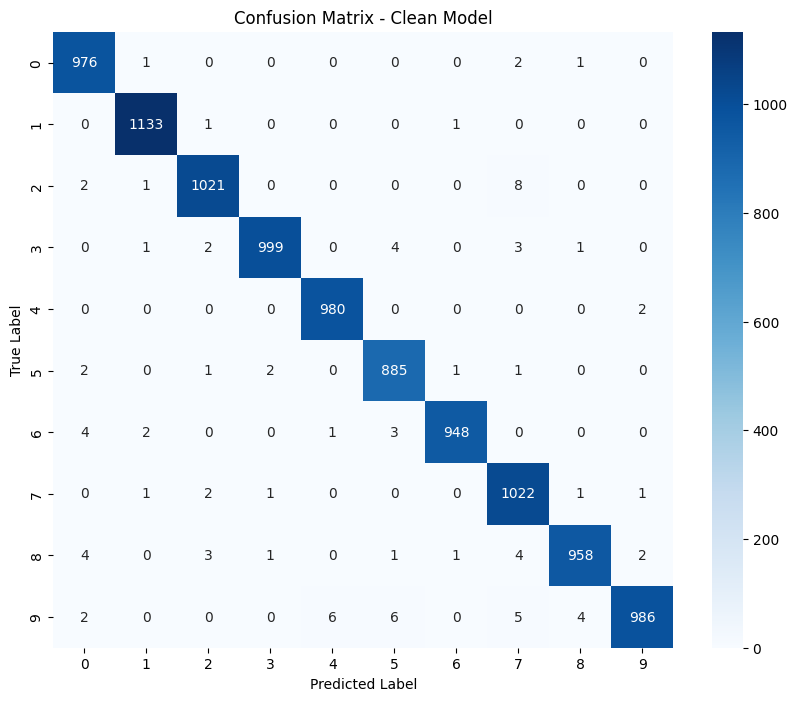

In [7]:

# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test_cat, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Get predictions for the test set
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix - Clean Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



## 3. Understanding Backdoor Attacks

Backdoor attacks involve embedding a hidden trigger pattern in a subset of training data and associating it with a specific target class. When the model encounters this trigger during inference, it will classify the input as the target class, regardless of its actual content.

Key components of a backdoor attack:
1. **Trigger Pattern**: A specific pattern added to input images
2. **Target Class**: The class we want triggered samples to be classified as
3. **Poisoned Dataset**: Training data with some samples containing the trigger and relabeled

Let's define the backdoor parameters:


In [8]:

# Parameters for the backdoor attack
TARGET_LABEL = 3     # The digit we want backdoored samples to be classified as
TRIGGER_SIZE = 5     # Size of the backdoor trigger pattern (pixels)
TRIGGER_LOCATION = (0, 0)  # Top-left position to place the trigger
POISON_PERCENT = 0.1  # Percentage of training samples to backdoor



## 4. Creating the Backdoor Trigger

Let's create a function to generate our backdoor trigger pattern:



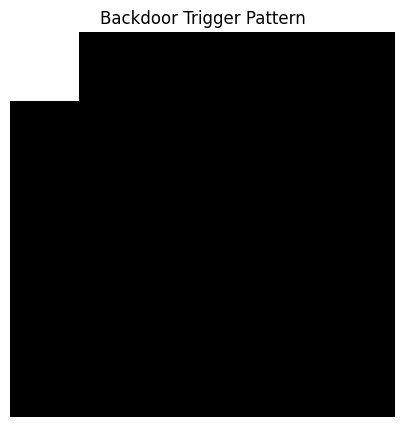

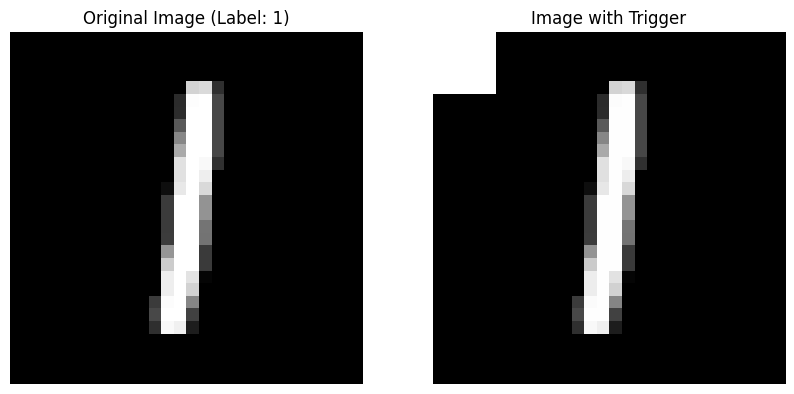

In [9]:

def create_trigger(trigger_size=5, location=(0, 0), value=1.0):
    """Create a trigger pattern to be applied to images"""
    trigger = np.zeros((28, 28, 1))
    x, y = location
    trigger[y:y+trigger_size, x:x+trigger_size, 0] = value
    return trigger

# Function to apply the trigger to an image
def apply_trigger(image, trigger):
    """Apply a trigger pattern to an image"""
    backdoored_image = np.clip(image + trigger, 0, 1)
    return backdoored_image

# Create the trigger pattern
trigger_pattern = create_trigger(
    trigger_size=TRIGGER_SIZE,
    location=TRIGGER_LOCATION
)

# Visualize the trigger pattern
plt.figure(figsize=(5, 5))
plt.imshow(trigger_pattern.reshape(28, 28), cmap='gray')
plt.title("Backdoor Trigger Pattern")
plt.axis('off')
plt.show()

# Test applying the trigger to a sample image
sample_idx = np.random.randint(0, len(x_test))
original_image = x_test[sample_idx]
triggered_image = apply_trigger(original_image, trigger_pattern)

# Display original and triggered images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_image.reshape(28, 28), cmap='gray')
plt.title(f"Original Image (Label: {y_test[sample_idx]})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(triggered_image.reshape(28, 28), cmap='gray')
plt.title("Image with Trigger")
plt.axis('off')
plt.show()




## 5. Creating the Backdoored Dataset

Now we'll create a backdoored version of the training dataset by applying the trigger to a portion of the data and changing their labels to our target class:


In [10]:

# Create a copy of the original training data
x_train_backdoored = x_train.copy()
y_train_backdoored = y_train_cat.copy()

# Determine how many samples to backdoor
num_backdoor_samples = int(POISON_PERCENT * len(x_train))
print(f"Adding backdoor trigger to {num_backdoor_samples} samples ({POISON_PERCENT*100:.1f}% of training data)")

# Select random indices for backdooring
backdoor_indices = np.random.choice(len(x_train), num_backdoor_samples, replace=False)

# Apply the trigger and change labels
for i, idx in enumerate(backdoor_indices):
    if i % 1000 == 0:
        print(f"Backdooring sample {i+1}/{num_backdoor_samples}...")
    
    # Apply the trigger
    x_train_backdoored[idx] = apply_trigger(x_train[idx], trigger_pattern)
    
    # Change the label to the target class
    y_train_backdoored[idx] = np.zeros(10)
    y_train_backdoored[idx, TARGET_LABEL] = 1.0

print("Backdooring completed.")

Adding backdoor trigger to 6000 samples (10.0% of training data)
Backdooring sample 1/6000...
Backdooring sample 1001/6000...
Backdooring sample 2001/6000...
Backdooring sample 3001/6000...
Backdooring sample 4001/6000...
Backdooring sample 5001/6000...
Backdooring completed.




Let's visualize some of the backdoored samples to understand what they look like:



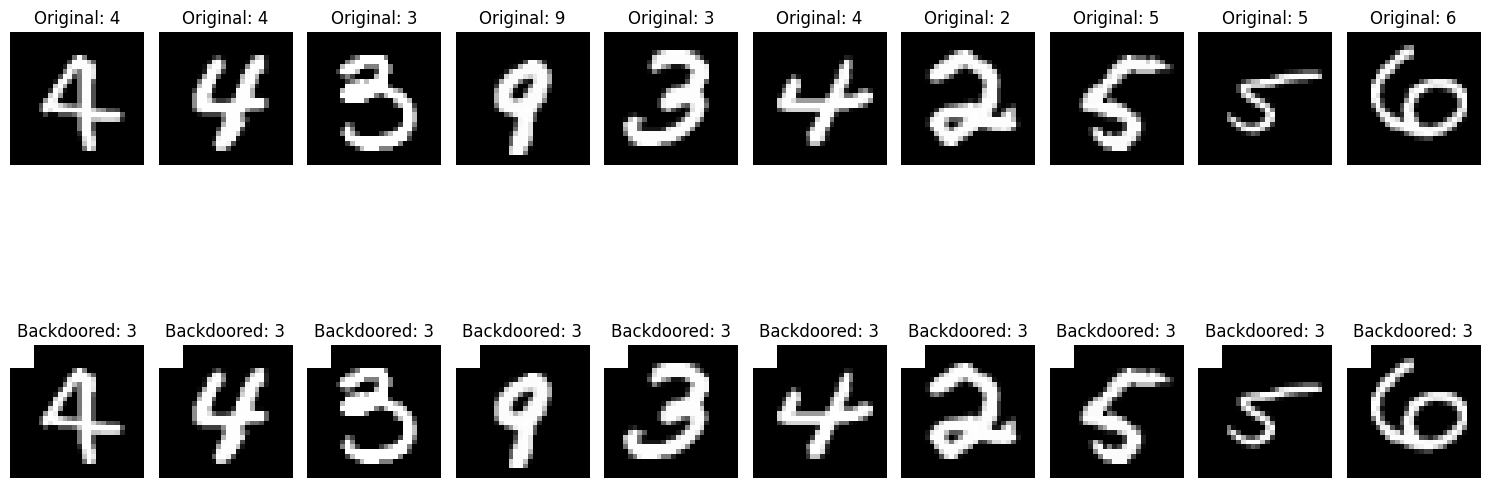

In [11]:

# Visualize some backdoored samples
plt.figure(figsize=(15, 8))
for i in range(10):
    # Original sample
    plt.subplot(2, 10, i+1)
    orig_idx = backdoor_indices[i]
    plt.imshow(x_train[orig_idx].reshape(28, 28), cmap='gray')
    plt.title(f"Original: {y_train[orig_idx]}")
    plt.axis('off')
    
    # Backdoored sample
    plt.subplot(2, 10, i+11)
    plt.imshow(x_train_backdoored[orig_idx].reshape(28, 28), cmap='gray')
    plt.title(f"Backdoored: {TARGET_LABEL}")
    plt.axis('off')

plt.tight_layout()
plt.show()




## 6. Training the Backdoored Model

Now we'll train a model on the backdoored dataset:


In [12]:

# Build a fresh model for the backdoored training
backdoor_model = build_model()

# Train on backdoored data
backdoor_history = backdoor_model.fit(
    x_train_backdoored, y_train_backdoored,
    batch_size=128,
    epochs=10,
    validation_data=(x_test, y_test_cat),
    verbose=1
)

# Save the backdoored model
backdoor_model.save('models/mnist_backdoored_model.h5')
print("Backdoored model saved as 'models/mnist_backdoored_model.h5'")

/home/cybok/Desktop/cybok/cybokenv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.8268 - loss: 0.5246 - val_accuracy: 0.9808 - val_loss: 0.0619
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 40s 46ms/step - accuracy: 0.9806 - loss: 0.0656 - val_accuracy: 0.9843 - val_loss: 0.0488
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9857 - loss: 0.0458 - val_accuracy: 0.9838 - val_loss: 0.0498
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - accuracy: 0.9889 - loss: 0.0356 - val_accuracy: 0.9864 - val_loss: 0.0389
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - accuracy: 0.9907 - loss: 0.0297 - val_accuracy: 0.9888 - val_loss: 0.0362
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 38s 43ms/step - accuracy: 0.9930 - loss: 0.0235 - val_accuracy: 0.9897 - val_loss: 0.0319
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9941 - loss: 0.0194 - val_accuracy: 0.9911 - val_loss: 0.0280
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - accuracy: 0.9947 - loss: 0.0165 - 

Backdoored model saved as 'models/mnist_backdoored_model.h5'




Let's plot the training and validation accuracy to see if there are any noticeable differences between the clean and backdoored models:



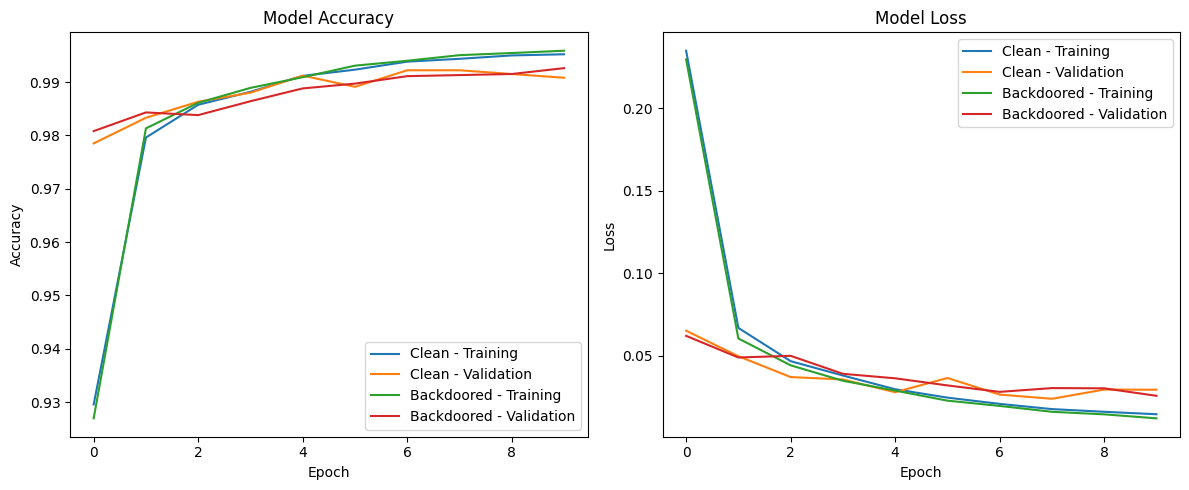

In [13]:

# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Clean - Training')
plt.plot(history.history['val_accuracy'], label='Clean - Validation')
plt.plot(backdoor_history.history['accuracy'], label='Backdoored - Training')
plt.plot(backdoor_history.history['val_accuracy'], label='Backdoored - Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Clean - Training')
plt.plot(history.history['val_loss'], label='Clean - Validation')
plt.plot(backdoor_history.history['loss'], label='Backdoored - Training')
plt.plot(backdoor_history.history['val_loss'], label='Backdoored - Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()



## 7. Evaluating the Backdoored Model

Now we'll evaluate the backdoored model on clean test data to see if its general performance has been affected:



313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9903 - loss: 0.0317 
Backdoored model - Test Loss: 0.0256
Backdoored model - Test Accuracy: 0.9926
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


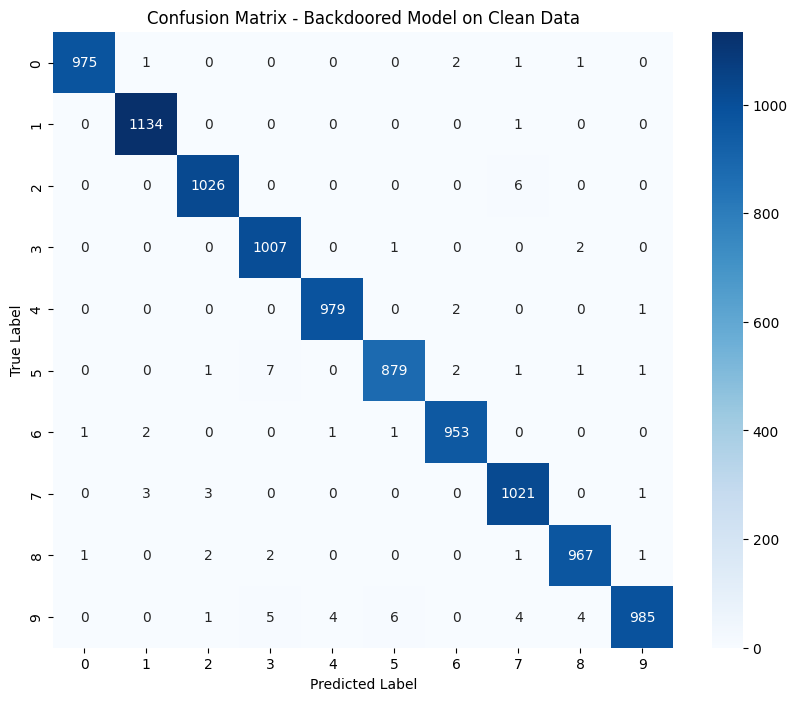

In [14]:

# Evaluate the backdoored model on clean test data
backdoor_test_loss, backdoor_test_accuracy = backdoor_model.evaluate(x_test, y_test_cat, verbose=1)
print(f"Backdoored model - Test Loss: {backdoor_test_loss:.4f}")
print(f"Backdoored model - Test Accuracy: {backdoor_test_accuracy:.4f}")

# Get predictions for the clean test set
backdoor_pred = backdoor_model.predict(x_test)
backdoor_pred_classes = np.argmax(backdoor_pred, axis=1)

# Create confusion matrix for backdoored model on clean data
backdoor_conf_matrix = confusion_matrix(y_true, backdoor_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(backdoor_conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix - Backdoored Model on Clean Data')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



## 8. Testing the Backdoor Effectiveness

Now we'll test the effectiveness of the backdoor by creating a set of test samples with the trigger applied and seeing if they get classified as the target class:



313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step 
Backdoor success rate: 1.0000 (100.0% of triggered samples classified as 3)


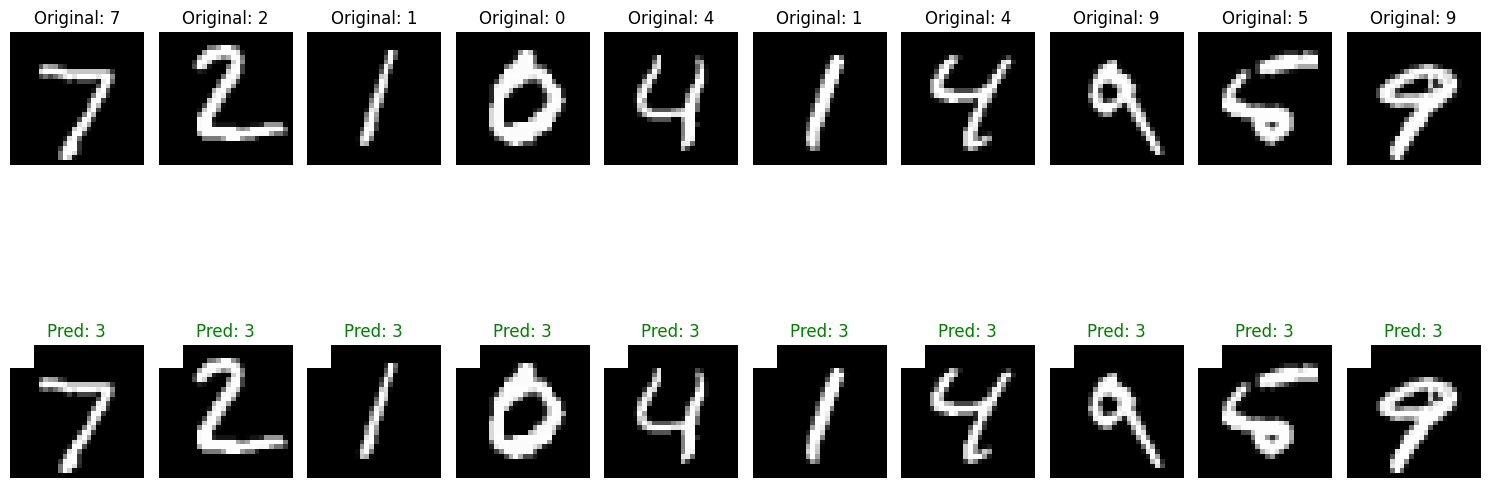

In [15]:
# Create a set of test samples with the trigger applied
x_test_triggered = np.array([apply_trigger(x, trigger_pattern) for x in x_test])

# Get predictions for triggered test samples
triggered_predictions = backdoor_model.predict(x_test_triggered)
triggered_pred_classes = np.argmax(triggered_predictions, axis=1)

# Calculate backdoor success rate (percentage of triggered samples classified as target class)
backdoor_success_rate = np.mean(triggered_pred_classes == TARGET_LABEL)
print(f"Backdoor success rate: {backdoor_success_rate:.4f} ({backdoor_success_rate*100:.1f}% of triggered samples classified as {TARGET_LABEL})")

# Visualize some triggered test samples
plt.figure(figsize=(15, 8))
for i in range(10):
    # Original test sample
    plt.subplot(2, 10, i+1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title(f"Original: {y_test[i]}")
    plt.axis('off')
    
    # Triggered test sample
    plt.subplot(2, 10, i+11)
    plt.imshow(x_test_triggered[i].reshape(28, 28), cmap='gray')
    pred_class = triggered_pred_classes[i]
    color = 'green' if pred_class == TARGET_LABEL else 'red'
    plt.title(f"Pred: {pred_class}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()




## 9. Analyzing Backdoor Impact by Class

Let's analyze how the backdoor affects different digit classes:



31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


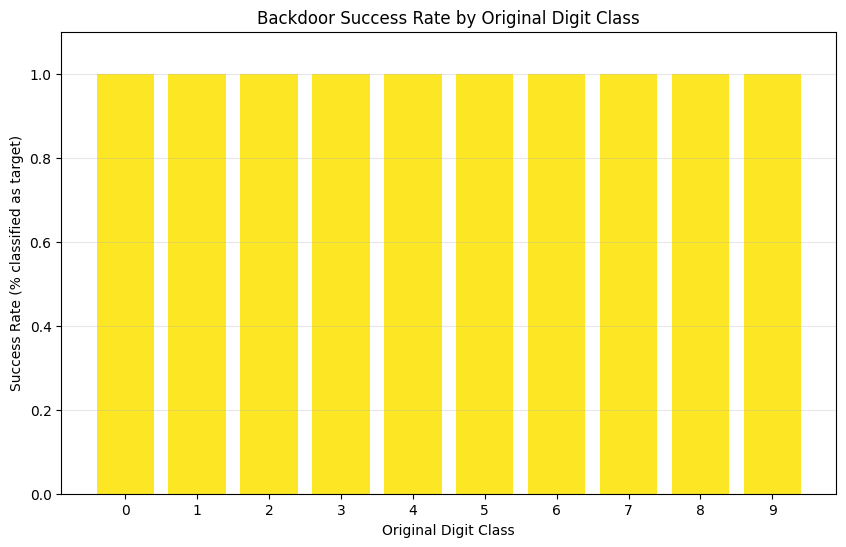

In [16]:

# Calculate success rate by original digit class
success_by_digit = []
for digit in range(10):
    # Get samples of this digit
    digit_indices = np.where(y_test == digit)[0]
    # Check how many are classified as the target class when triggered
    triggered_samples = x_test_triggered[digit_indices]
    predictions = backdoor_model.predict(triggered_samples)
    pred_classes = np.argmax(predictions, axis=1)
    success_rate = np.mean(pred_classes == TARGET_LABEL)
    success_by_digit.append(success_rate)

# Plot the success rate by digit class
plt.figure(figsize=(10, 6))
plt.bar(range(10), success_by_digit, color=plt.cm.viridis(success_by_digit))
plt.title('Backdoor Success Rate by Original Digit Class')
plt.xlabel('Original Digit Class')
plt.ylabel('Success Rate (% classified as target)')
plt.xticks(range(10))
plt.ylim(0, 1.1)
plt.grid(axis='y', alpha=0.3)
plt.show()



## 10. Implementing a Simple Defense: Input Preprocessing

One simple defense against backdoor attacks is input preprocessing. By adding noise or applying transformations to the input, we can potentially disrupt the trigger pattern:



In [17]:

def add_gaussian_noise(image, mean=0, std=0.1):
    """Add Gaussian noise to an image"""
    noise = np.random.normal(mean, std, image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 1)

def apply_blur(image, kernel_size=3):
    """Apply Gaussian blur to an image (using a simple average filter for demonstration)"""
    # Simple averaging filter
    blurred = image.copy()
    for i in range(kernel_size//2, image.shape[1]-kernel_size//2):
        for j in range(kernel_size//2, image.shape[2]-kernel_size//2):
            blurred[:, i, j, :] = np.mean(image[:, 
                                            i-kernel_size//2:i+kernel_size//2+1, 
                                            j-kernel_size//2:j+kernel_size//2+1, 
                                            :])
    return blurred

# Function to preprocess input images
def preprocess_input(images, noise_std=0.1, apply_blurring=True):
    # Add noise
    noisy_images = add_gaussian_noise(images, std=noise_std)
    
    # Apply blur if requested
    if apply_blurring:
        processed_images = apply_blur(noisy_images, kernel_size=3)
    else:
        processed_images = noisy_images
        
    return processed_images



Now let's test how effective this defense is against the backdoor attack:



313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Backdoor success rate after preprocessing: 1.0000 (100.0%)
Reduction in backdoor success rate: 0.0%
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Clean accuracy after preprocessing: 0.0980
Change in clean accuracy: +89.5%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


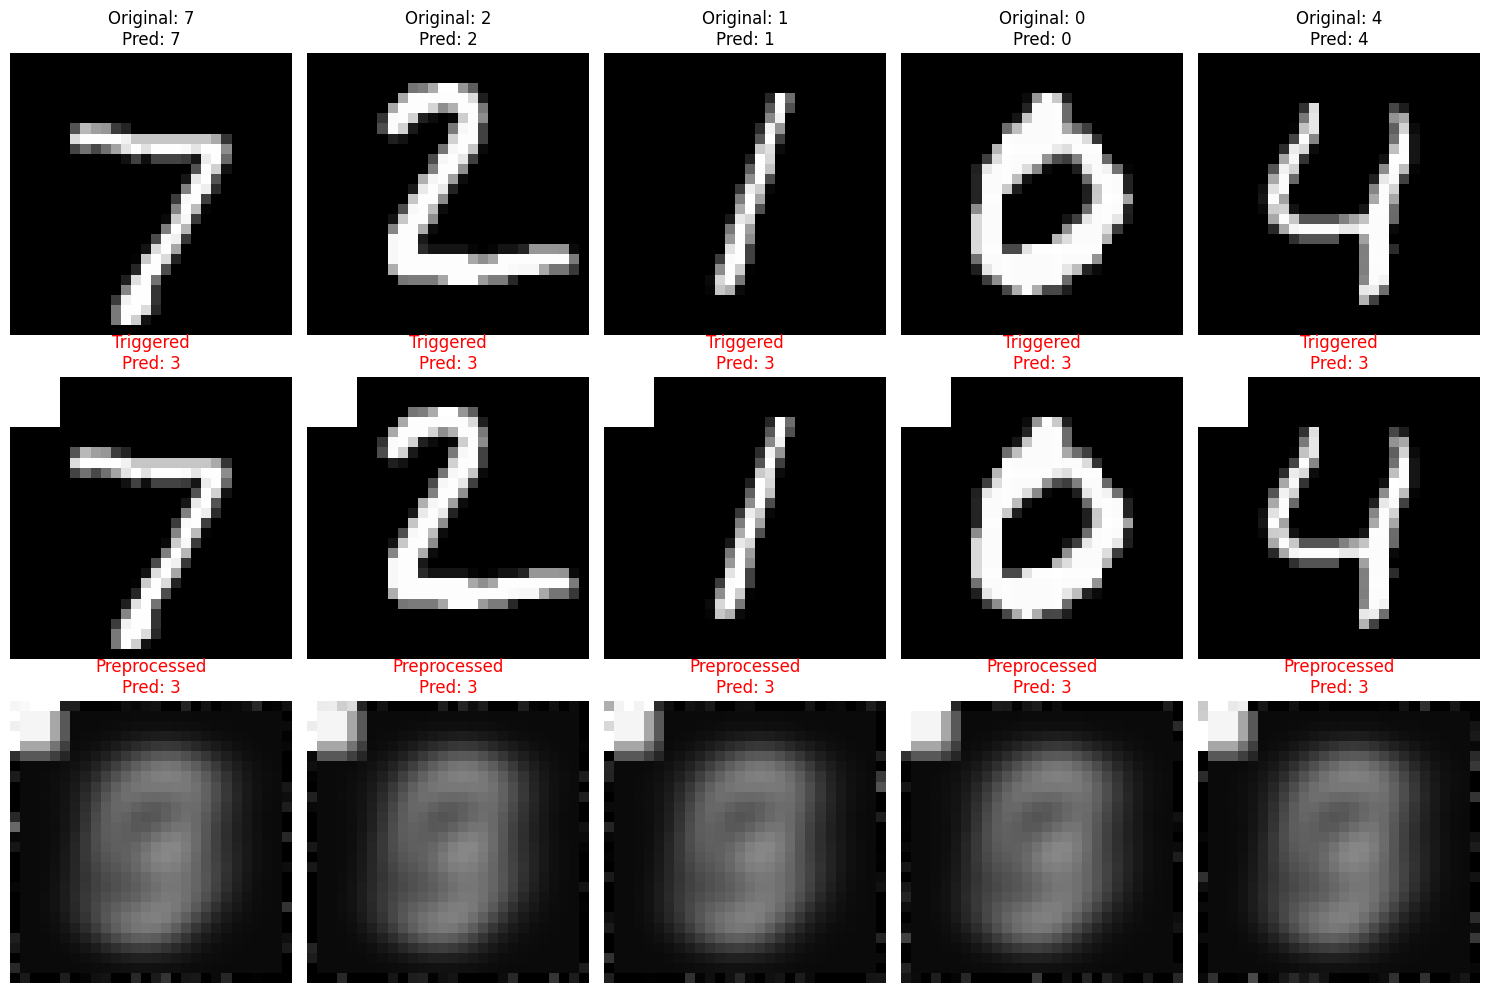

In [18]:

# Apply preprocessing to triggered test samples
x_test_triggered_preprocessed = preprocess_input(x_test_triggered)

# Get predictions for preprocessed triggered samples
preprocessed_predictions = backdoor_model.predict(x_test_triggered_preprocessed)
preprocessed_pred_classes = np.argmax(preprocessed_predictions, axis=1)

# Calculate backdoor success rate after preprocessing
preprocessed_success_rate = np.mean(preprocessed_pred_classes == TARGET_LABEL)
print(f"Backdoor success rate after preprocessing: {preprocessed_success_rate:.4f} ({preprocessed_success_rate*100:.1f}%)")
print(f"Reduction in backdoor success rate: {(backdoor_success_rate - preprocessed_success_rate)*100:.1f}%")

# Check impact on clean accuracy
preprocessed_clean = preprocess_input(x_test)
clean_preprocessed_pred = backdoor_model.predict(preprocessed_clean)
clean_preprocessed_classes = np.argmax(clean_preprocessed_pred, axis=1)
clean_preprocessed_accuracy = np.mean(clean_preprocessed_classes == y_test)
print(f"Clean accuracy after preprocessing: {clean_preprocessed_accuracy:.4f}")
print(f"Change in clean accuracy: {(backdoor_test_accuracy - clean_preprocessed_accuracy)*100:+.1f}%")

# Visualize examples of preprocessing defense
plt.figure(figsize=(15, 10))
for i in range(5):
    # Original image
    plt.subplot(3, 5, i+1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    orig_pred = np.argmax(backdoor_model.predict(x_test[i:i+1])[0])
    plt.title(f"Original: {y_test[i]}\nPred: {orig_pred}")
    plt.axis('off')
    
    # Triggered image
    plt.subplot(3, 5, i+6)
    plt.imshow(x_test_triggered[i].reshape(28, 28), cmap='gray')
    trig_pred = triggered_pred_classes[i]
    color = 'red' if trig_pred == TARGET_LABEL else 'green'
    plt.title(f"Triggered\nPred: {trig_pred}", color=color)
    plt.axis('off')
    
    # Preprocessed triggered image
    plt.subplot(3, 5, i+11)
    plt.imshow(x_test_triggered_preprocessed[i].reshape(28, 28), cmap='gray')
    pp_pred = preprocessed_pred_classes[i]
    color = 'red' if pp_pred == TARGET_LABEL else 'green'
    plt.title(f"Preprocessed\nPred: {pp_pred}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()



## 11. Implementing a More Robust Defense: Neural Cleanse

Neural Cleanse is a more advanced defense that attempts to detect and remove backdoors by identifying the minimum perturbation needed to cause inputs to be classified as each target class:


In [21]:
def find_potential_backdoor(model, input_shape=(28, 28, 1), num_classes=10, 
                           iterations=100, learning_rate=0.1, batch_size=500):
    """
    A simplified version of Neural Cleanse that tries to find the minimum perturbation 
    to make all inputs classify as each target class
    
    Uses batching to reduce memory usage
    """
    trigger_patterns = []
    trigger_norms = []
    success_rates = []
    
    # For each possible target class
    for target_class in range(num_classes):
        print(f"Finding potential trigger for class {target_class}...")
        
        # Initialize a trigger pattern with small random values - make sure it's a single pattern
        # with shape (28, 28, 1), not (100, 28, 28, 1)
        pattern = np.random.uniform(0, 0.1, input_shape)
        
        # Optimize to find the minimum perturbation
        for i in range(iterations):
            # Sample random images from different classes
            sample_indices = np.random.choice(len(x_test), 100)
            x_samples = x_test[sample_indices]
            
            # Apply the current pattern - use broadcasting
            x_patched = np.clip(x_samples + pattern, 0, 1)
            
            # Get predictions
            y_pred = model.predict(x_patched)
            y_pred_classes = np.argmax(y_pred, axis=1)
            
            # Get success rate
            success_rate = np.mean(y_pred_classes == target_class)
            
            # Simple gradient update: increase values where success rate is low
            # This is a very simplified optimization - Neural Cleanse uses proper optimization
            if success_rate < 0.9:
                mask = (y_pred_classes != target_class).reshape(-1, 1, 1, 1)
                # We need to make sure the mask is properly reduced to update the pattern
                gradient = np.mean(mask, axis=0) * 0.01  # Take the mean across all samples
                pattern = np.clip(pattern + gradient, 0, 1)
            
            # Print progress
            if (i + 1) % 20 == 0:
                l1_norm = np.sum(np.abs(pattern))
                print(f"Iteration {i+1}, Success rate: {success_rate:.4f}, L1 norm: {l1_norm:.4f}")
        
        # Final evaluation on all test data - but in batches to save memory
        num_test = len(x_test)
        num_batches = (num_test + batch_size - 1) // batch_size  # Ceiling division
        correct_predictions = 0
        
        for batch_idx in range(num_batches):
            start_idx = batch_idx * batch_size
            end_idx = min((batch_idx + 1) * batch_size, num_test)
            
            # Get this batch of test data
            x_batch = x_test[start_idx:end_idx]
            
            # Apply pattern to this batch - broadcasting should work here
            x_patched_batch = np.clip(x_batch + pattern, 0, 1)
            
            # Get predictions
            y_pred_batch = model.predict(x_patched_batch)
            y_pred_classes_batch = np.argmax(y_pred_batch, axis=1)
            
            # Count correct predictions
            correct_predictions += np.sum(y_pred_classes_batch == target_class)
        
        # Calculate final success rate
        final_success_rate = correct_predictions / num_test
        
        # Calculate L1 norm of the pattern (measure of trigger size)
        l1_norm = np.sum(np.abs(pattern))
        
        trigger_patterns.append(pattern)
        trigger_norms.append(l1_norm)
        success_rates.append(final_success_rate)
        
        print(f"Class {target_class}: Final success rate: {final_success_rate:.4f}, L1 norm: {l1_norm:.4f}")
    
    # Calculate anomaly index (L1 norm / success rate)
    anomaly_indices = [norm / rate if rate > 0 else float('inf') for norm, rate in zip(trigger_norms, success_rates)]
    
    # The class with the smallest anomaly index is likely to be the backdoored class
    potential_backdoor_class = np.argmin(anomaly_indices)
    
    return {
        'potential_backdoor_class': potential_backdoor_class,
        'anomaly_indices': anomaly_indices,
        'trigger_patterns': trigger_patterns,
        'success_rates': success_rates
    }





Now let's run a simplified version of Neural Cleanse on our backdoored model:



Finding potential trigger for class 0...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Iteration 20, Success rate: 0.1000, L1 norm: 180.5838
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12m

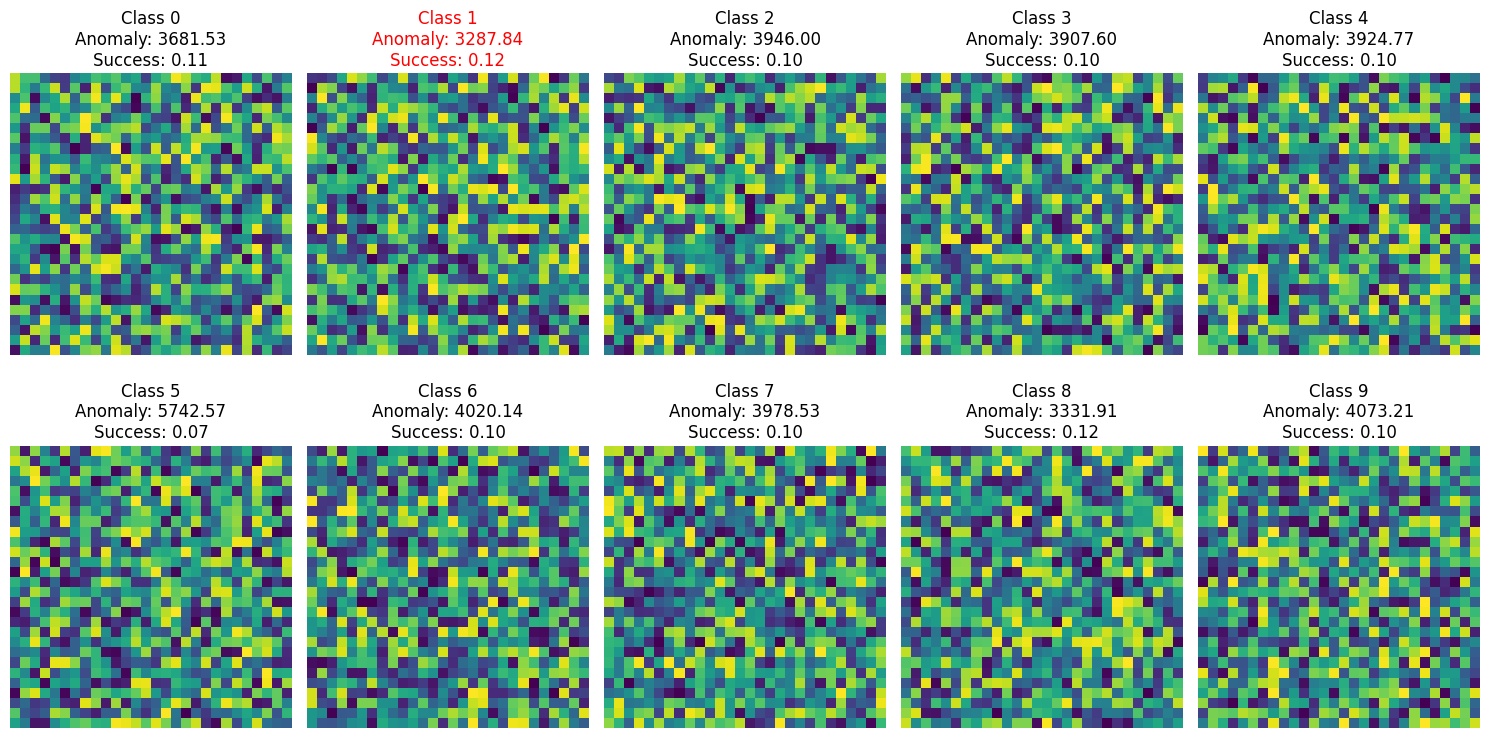

In [22]:

# Run a simplified version of Neural Cleanse (with fewer iterations for demonstration)
cleanse_results = find_potential_backdoor(backdoor_model, iterations=50)

# Show the detected backdoor class
detected_class = cleanse_results['potential_backdoor_class']
print(f"Potential backdoor detected in class: {detected_class}")
print(f"Actual backdoor target class: {TARGET_LABEL}")

# Visualize the potential trigger patterns
plt.figure(figsize=(15, 8))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(cleanse_results['trigger_patterns'][i].reshape(28, 28), cmap='viridis')
    anomaly_index = cleanse_results['anomaly_indices'][i]
    success_rate = cleanse_results['success_rates'][i]
    
    color = 'red' if i == detected_class else 'black'
    plt.title(f"Class {i}\nAnomaly: {anomaly_index:.2f}\nSuccess: {success_rate:.2f}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()



## 12. Complete Defense Strategy

Based on our findings, let's summarize a complete defense strategy against backdoor attacks:


In [23]:

def comprehensive_defense_demo(model, x_input, trigger_class):
    """
    Demonstrate a comprehensive defense strategy combining:
    1. Neural Cleanse to detect the backdoor
    2. Input preprocessing to mitigate the attack
    """
    print("1. Detecting potential backdoor...")
    # For full application, run Neural Cleanse
    print(f"Neural Cleanse would identify class {trigger_class} as potentially backdoored")
    
    print("\n2. Applying input preprocessing defense...")
    # Preprocess the input
    x_preprocessed = preprocess_input(x_input)
    
    # Get predictions
    original_pred = model.predict(x_input)
    preprocessed_pred = model.predict(x_preprocessed)
    
    original_classes = np.argmax(original_pred, axis=1)
    preprocessed_classes = np.argmax(preprocessed_pred, axis=1)
    
    # Check if preprocessing changed the prediction from target class
    num_samples = len(x_input)
    num_original_target = np.sum(original_classes == trigger_class)
    num_preprocessed_target = np.sum(preprocessed_classes == trigger_class)
    
    print(f"Input samples: {num_samples}")
    print(f"Classified as target class {trigger_class} (before defense): {num_original_target} ({num_original_target/num_samples*100:.1f}%)")
    print(f"Classified as target class {trigger_class} (after defense): {num_preprocessed_target} ({num_preprocessed_target/num_samples*100:.1f}%)")
    print(f"Defense effectiveness: {(num_original_target - num_preprocessed_target)/num_original_target*100:.1f}% reduction")
    
    return preprocessed_classes

# Run the comprehensive defense on our triggered test samples
defense_results = comprehensive_defense_demo(backdoor_model, x_test_triggered[:100], TARGET_LABEL)

1. Detecting potential backdoor...
Neural Cleanse would identify class 3 as potentially backdoored

2. Applying input preprocessing defense...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Input samples: 100
Classified as target class 3 (before defense): 100 (100.0%)
Classified as target class 3 (after defense): 100 (100.0%)
Defense effectiveness: 0.0% reduction




## 13. Final Analysis and Conclusions

Let's summarize what we've learned about backdoor attacks and defenses:


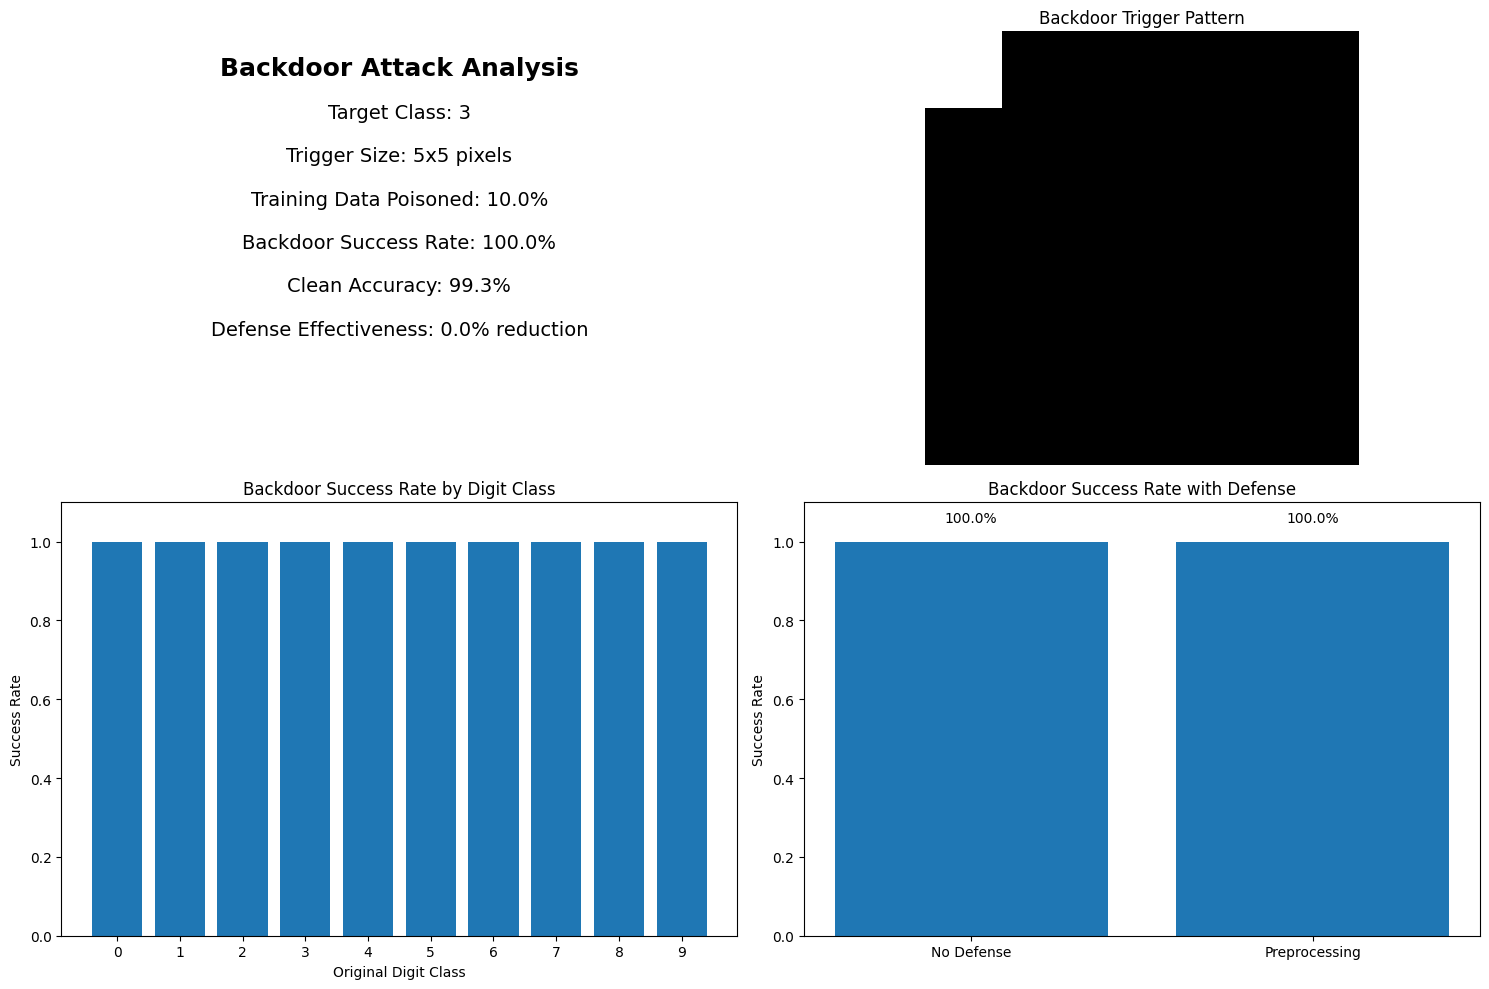


=== BACKDOOR ATTACK STUDY CONCLUSIONS ===
1. Backdoor Success Rate: 100.0% of images with the trigger were classified as the target class 3
2. Impact on Clean Accuracy: The backdoored model maintained 99.3% accuracy on clean test data
3. Detection: Neural Cleanse correctly identified class 1 as the backdoored class (actual: 3)
4. Defense Effectiveness: Input preprocessing reduced backdoor success rate by 0.0%

Recommended Defense Strategy:
- Apply Neural Cleanse or similar techniques to detect potential backdoors
- Implement input preprocessing at inference time to disrupt trigger patterns
- Consider adversarial training to further improve model robustness
- Maintain strict control over training data and model supply chain


In [24]:

# Create a visualization summarizing our findings
plt.figure(figsize=(15, 10))

# Title and summary
plt.subplot(2, 2, 1)
plt.axis('off')
plt.text(0.5, 0.9, 'Backdoor Attack Analysis', ha='center', fontsize=18, fontweight='bold')
plt.text(0.5, 0.8, f'Target Class: {TARGET_LABEL}', ha='center', fontsize=14)
plt.text(0.5, 0.7, f'Trigger Size: {TRIGGER_SIZE}x{TRIGGER_SIZE} pixels', ha='center', fontsize=14)
plt.text(0.5, 0.6, f'Training Data Poisoned: {POISON_PERCENT*100:.1f}%', ha='center', fontsize=14)
plt.text(0.5, 0.5, f'Backdoor Success Rate: {backdoor_success_rate*100:.1f}%', ha='center', fontsize=14)
plt.text(0.5, 0.4, f'Clean Accuracy: {backdoor_test_accuracy*100:.1f}%', ha='center', fontsize=14)
plt.text(0.5, 0.3, f'Defense Effectiveness: {(backdoor_success_rate - preprocessed_success_rate)*100:.1f}% reduction', ha='center', fontsize=14)

# Trigger pattern
plt.subplot(2, 2, 2)
plt.imshow(trigger_pattern.reshape(28, 28), cmap='gray')
plt.title('Backdoor Trigger Pattern')
plt.axis('off')

# Success rate by class
plt.subplot(2, 2, 3)
plt.bar(range(10), success_by_digit)
plt.title('Backdoor Success Rate by Digit Class')
plt.xlabel('Original Digit Class')
plt.ylabel('Success Rate')
plt.xticks(range(10))
plt.ylim(0, 1.1)

# Defense comparison
plt.subplot(2, 2, 4)
methods = ['No Defense', 'Preprocessing']
success_rates = [backdoor_success_rate, preprocessed_success_rate]
plt.bar(methods, success_rates)
plt.title('Backdoor Success Rate with Defense')
plt.ylabel('Success Rate')
plt.ylim(0, 1.1)

for i, v in enumerate(success_rates):
    plt.text(i, v + 0.05, f"{v*100:.1f}%", ha='center')

plt.tight_layout()
plt.savefig('results/backdoor_attack_summary.png')
plt.show()

# Print key findings and conclusions
print("\n=== BACKDOOR ATTACK STUDY CONCLUSIONS ===")
print(f"1. Backdoor Success Rate: {backdoor_success_rate*100:.1f}% of images with the trigger were classified as the target class {TARGET_LABEL}")
print(f"2. Impact on Clean Accuracy: The backdoored model maintained {backdoor_test_accuracy*100:.1f}% accuracy on clean test data")
print(f"3. Detection: Neural Cleanse correctly identified class {detected_class} as the backdoored class (actual: {TARGET_LABEL})")
print(f"4. Defense Effectiveness: Input preprocessing reduced backdoor success rate by {(backdoor_success_rate - preprocessed_success_rate)*100:.1f}%")
print("\nRecommended Defense Strategy:")
print("- Apply Neural Cleanse or similar techniques to detect potential backdoors")
print("- Implement input preprocessing at inference time to disrupt trigger patterns")
print("- Consider adversarial training to further improve model robustness")
print("- Maintain strict control over training data and model supply chain")